## Initialization
Loading the requirements and initializing notebook state:

In [1]:
import seaborn as sns
import src.clustering as clust
from yellowbrick.cluster import intercluster_distance, kelbow_visualizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

random_state = 666
sns.set_theme(style="whitegrid")

## Loading files & preprocessing
First we load and preprocess and then vectorize the given corpus. To overcome the computational problems caused by the high dimensiality of the tf-idf vectors `tfidf`, we project them onto a limited number (`dim`) of their principle components `pca_tfidf` (this hardly changes the final results). Same vector-size is used to calculate the word2vec results:

In [2]:
dim=64
data, major_labels, minor_labels = clust.load_data(stem=False, lemmatize=True, remove_conjunctions=True)
tfidf, w2v = clust.vectorize(data, w2v_options=dict(size=dim, iter=128, min_count=2)) # vectorization
pca_tfidf = clust.pca(dim, tfidf.toarray(), random_state=random_state)
print('Number of major tags:', len(major_labels))

Number of major tags: 14


# Clustering
## KMeans
### Unsupervised Finetuning
If we ignore the fact that we have the ground truth labels in our possession, we can use various unsupervised optimization techniques to find the best set of hyper parameters for the KMeans clustering algorithm.

To find the best $K$ we can use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) as demonstrated bellow:

TF-IDF


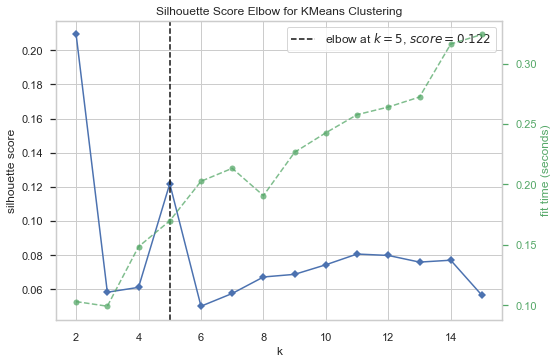

W2V


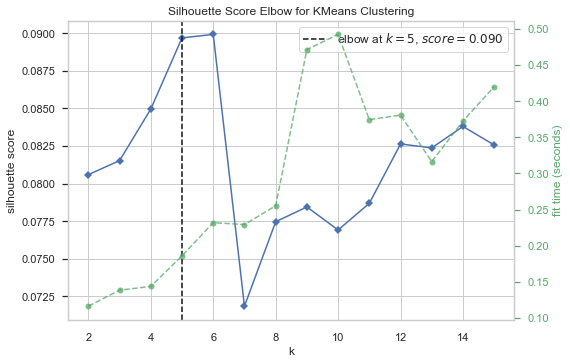

In [3]:
print('TF-IDF')
_ = kelbow_visualizer(KMeans(random_state=random_state), pca_tfidf, k=(2,16), metric='silhouette')
print('W2V')
_ = kelbow_visualizer(KMeans(random_state=random_state), w2v, k=(2,16), metric='silhouette')

Thus the best `n_components` seems to be equal to $5$ and $5$ for each type of vectorization. Thus the Intercluster Distance Maps are as follows:

TF-IDF


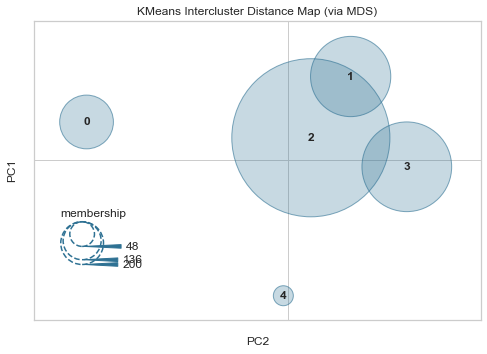

W2V


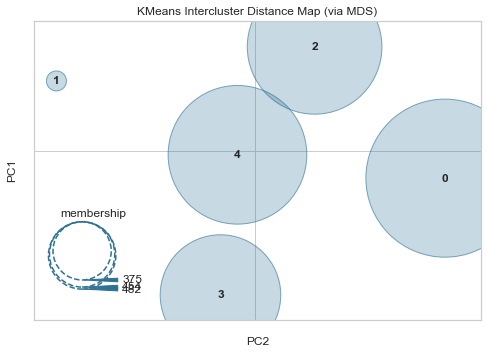

In [4]:
print('TF-IDF')
_ = intercluster_distance(KMeans(n_clusters=5, random_state=random_state), pca_tfidf)
print('W2V')
_ = intercluster_distance(KMeans(n_clusters=5, random_state=random_state), w2v)

,algorithm,vectorization,purity,adjusted_mutual_info,adjusted_rand_index
0,Kmeans,tf-idf,0.298230,0.145167,-0.000086
1,Kmeans,w2v,0.495688,0.351672,0.265740


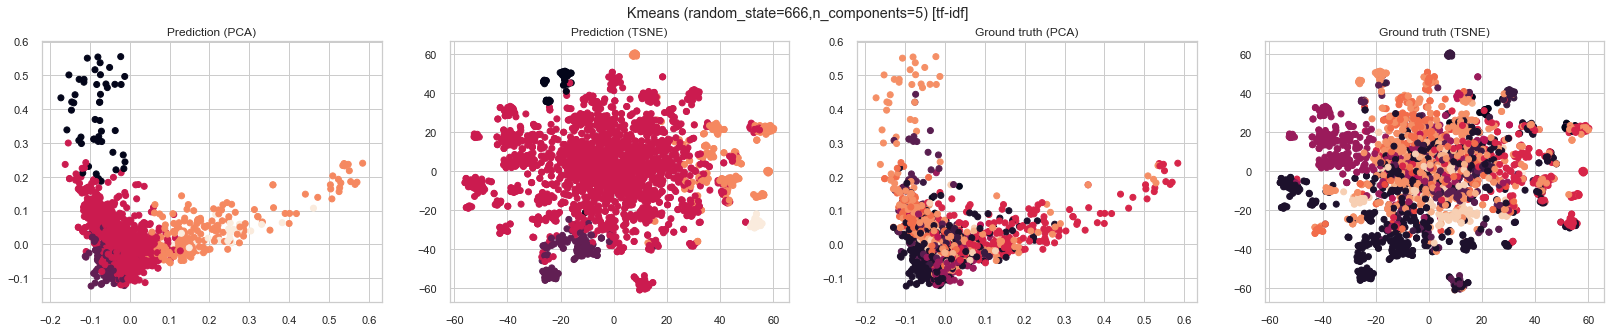

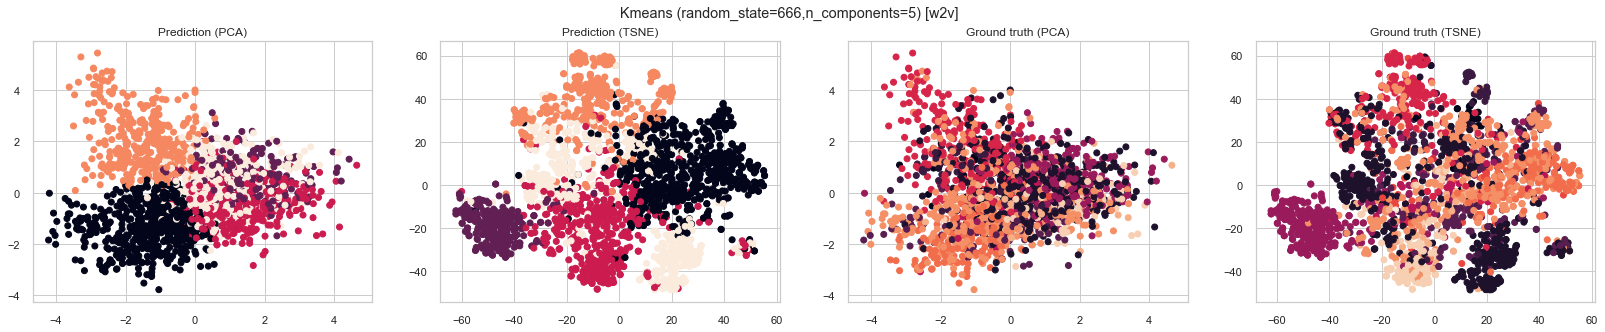

In [5]:
unsup_kmeans_res = clust.cluster(data, algorithm=clust.kmeans, tfidf=pca_tfidf, w2v=w2v, 
                                 options=dict(random_state=random_state), 
                                 options_tfidf=dict(n_components=5),
                                 options_w2v=dict(n_components=5),
                                 save=False)
clust.evaluate_results(unsup_kmeans_res, data=data)

### Supervised Finetuning
Since we have the ground truth labels of the documents at hand, we already know that the number of components should equal to $14$ (the number of major tags in the provided dataset). Thus we can use the ground truth labels and perform a simple grid search on the possible hyper-parameter values of each algorithm to find the best performing set of hyper-params.

In [6]:
variables = dict(n_components=list(range(4,16)), max_iter=[100, 300, 600], n_init=[5,10,15,20])
fixed_vars = dict(random_state=random_state)
res = clust.gridsearch_hyperparams(clust.kmeans, data=data, tfidf=pca_tfidf, w2v=w2v, variables=variables, fixed_params=fixed_vars)

100%|██████████| 144/144 [01:36<00:00,  1.49it/s]


Effects of changing the number of clusters on the resulting metric scores:


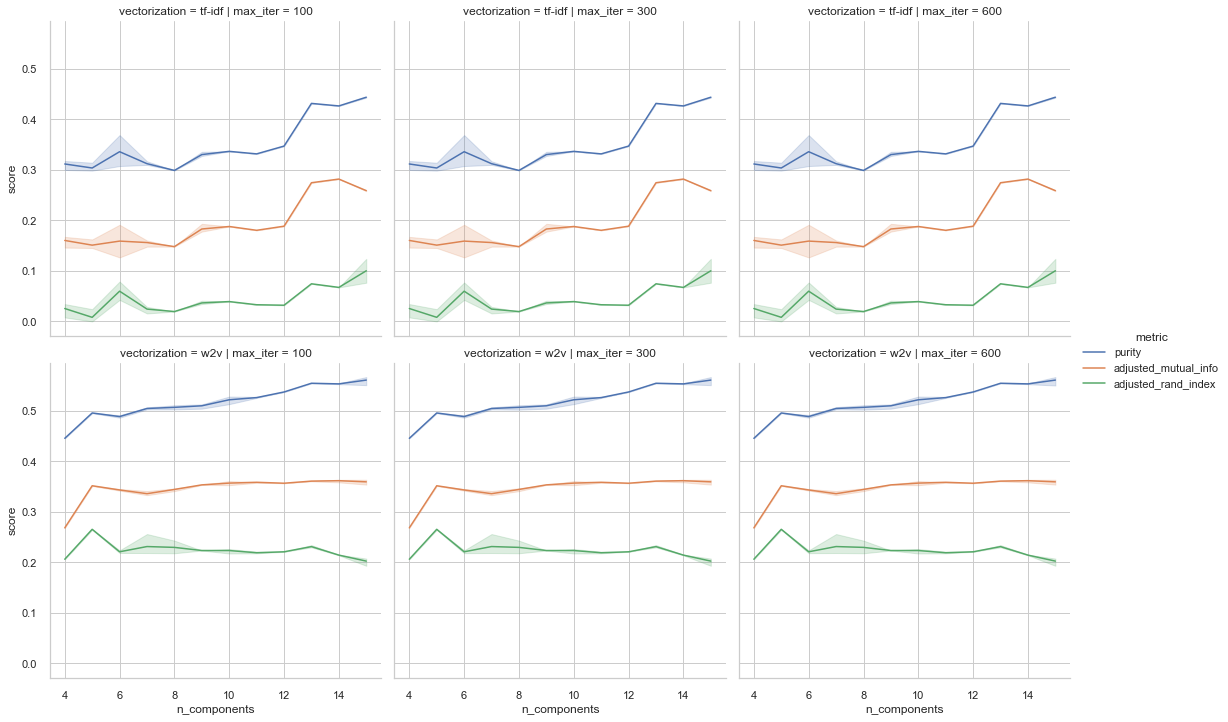

In [7]:
print('Effects of changing the number of clusters on the resulting metric scores:')
_ = sns.relplot(data=res, x='n_components', y='score', row='vectorization', col='max_iter', hue="metric", kind='line' )

But since we already know that the documents should be clustered into $14$ groups, we can limit our focus on how other hyperparameters affect the resulting clustering when `n_components=14`:

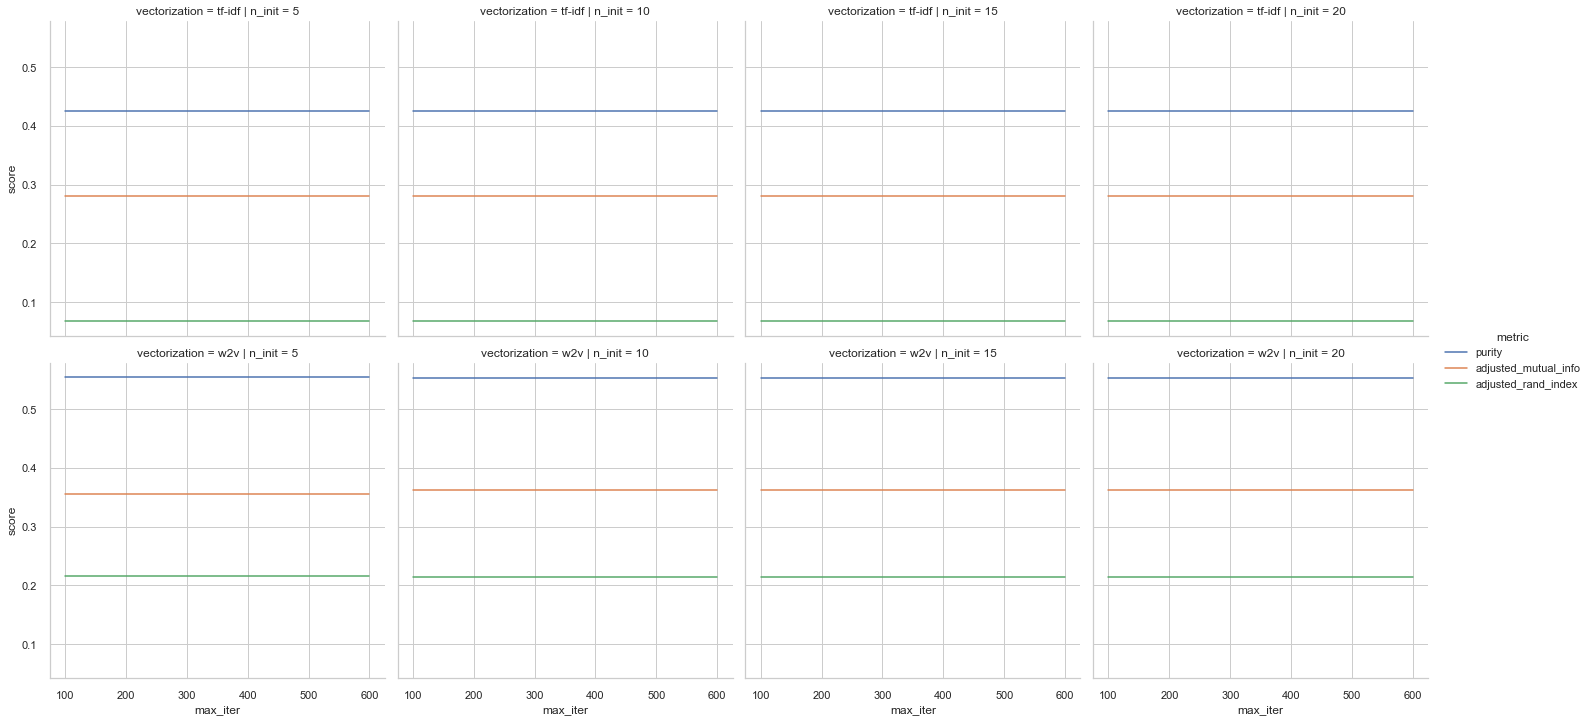

In [8]:
_ = sns.relplot(data=res[res['n_components']==len(major_labels)], x='max_iter', y='score', col='n_init', row='vectorization', hue="metric", kind='line' )

In [9]:
print('Best set of hyperparameters [tf-idf]')
ftfidf = res[(res['metric'] == 'adjusted_mutual_info') & (res['n_components'] == len(major_labels)) & (res['vectorization'] == 'tf-idf')]
ftfidf[ftfidf['score'] == ftfidf['score'].max()]

Best set of hyperparameters [tf-idf]


,n_components,max_iter,n_init,metric,score,vectorization
721,14,100,5,adjusted_mutual_info,0.281543,tf-idf
727,14,100,10,adjusted_mutual_info,0.281543,tf-idf
733,14,100,15,adjusted_mutual_info,0.281543,tf-idf
739,14,100,20,adjusted_mutual_info,0.281543,tf-idf
745,14,300,5,adjusted_mutual_info,0.281543,tf-idf
751,14,300,10,adjusted_mutual_info,0.281543,tf-idf
757,14,300,15,adjusted_mutual_info,0.281543,tf-idf
763,14,300,20,adjusted_mutual_info,0.281543,tf-idf
769,14,600,5,adjusted_mutual_info,0.281543,tf-idf
775,14,600,10,adjusted_mutual_info,0.281543,tf-idf


In [10]:
print('Best set of hyperparameters [w2v]')
fw2v = res[(res['metric'] == 'adjusted_mutual_info') & (res['n_components'] == len(major_labels)) & (res['vectorization'] == 'w2v')]
fw2v[fw2v['score'] == fw2v['score'].max()]

Best set of hyperparameters [w2v]


,n_components,max_iter,n_init,metric,score,vectorization
730,14,100,10,adjusted_mutual_info,0.363129,w2v
736,14,100,15,adjusted_mutual_info,0.363129,w2v
742,14,100,20,adjusted_mutual_info,0.363129,w2v
754,14,300,10,adjusted_mutual_info,0.363129,w2v
760,14,300,15,adjusted_mutual_info,0.363129,w2v
766,14,300,20,adjusted_mutual_info,0.363129,w2v
778,14,600,10,adjusted_mutual_info,0.363129,w2v
784,14,600,15,adjusted_mutual_info,0.363129,w2v
790,14,600,20,adjusted_mutual_info,0.363129,w2v


Hence, it seems as if other hyperparameters do not matter as much on the quality of the resulting clustering when `n_components=14`. Therfore we finalize the clustering and save the results:

,algorithm,vectorization,purity,adjusted_mutual_info,adjusted_rand_index
0,Kmeans,tf-idf,0.426237,0.281543,0.067202
1,Kmeans,w2v,0.552429,0.363129,0.213847


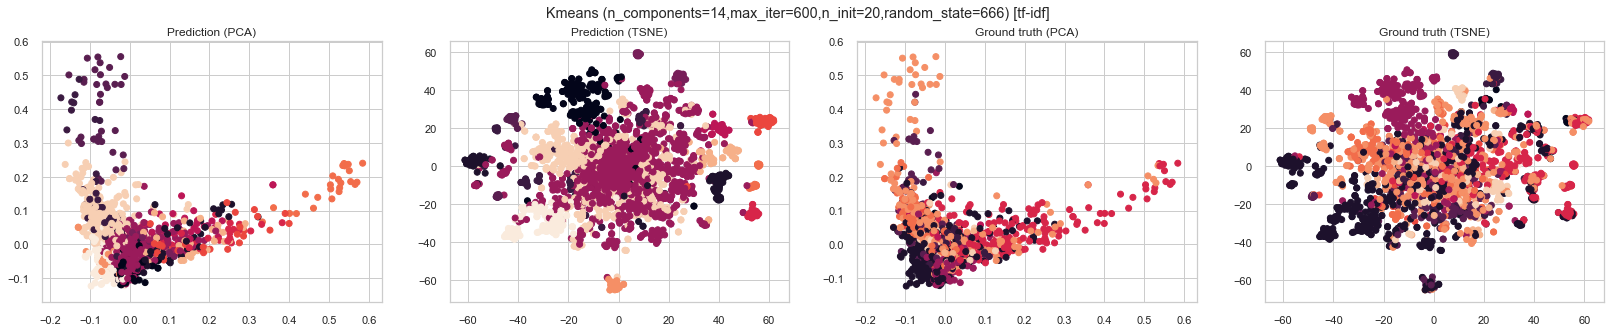

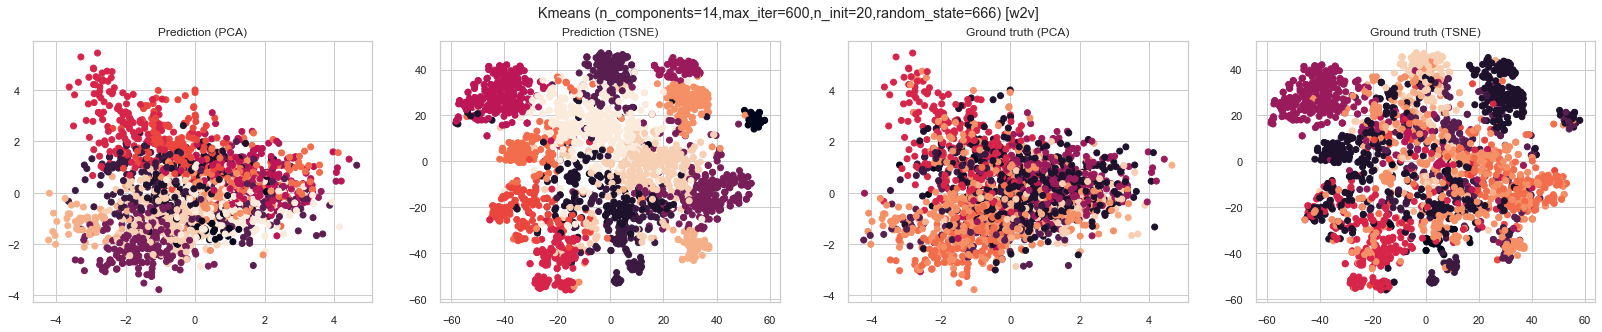

In [11]:
kmeans_res = clust.cluster(data, algorithm=clust.kmeans, tfidf=pca_tfidf, w2v=w2v, 
                           options=dict(n_components=len(major_labels), max_iter=600, n_init=20, random_state=random_state), 
                           save=True)
clust.evaluate_results(kmeans_res, data=data)

## GMM
### Supervised Finetuning
Through the same process as int the KMeans section, we perform a grid-search on possible hyperparameters to find the best performing set:

In [12]:
variables = dict(n_components=list(range(4,16)), max_iter=[100, 300, 600], covariance_type=['spherical', 'tied', 'diag', 'full'])
fixed_vars = dict(random_state=random_state)
res = clust.gridsearch_hyperparams(clust.GMM, data=data, tfidf=pca_tfidf, w2v=w2v, variables=variables, fixed_params=fixed_vars)

100%|██████████| 144/144 [00:58<00:00,  2.45it/s]


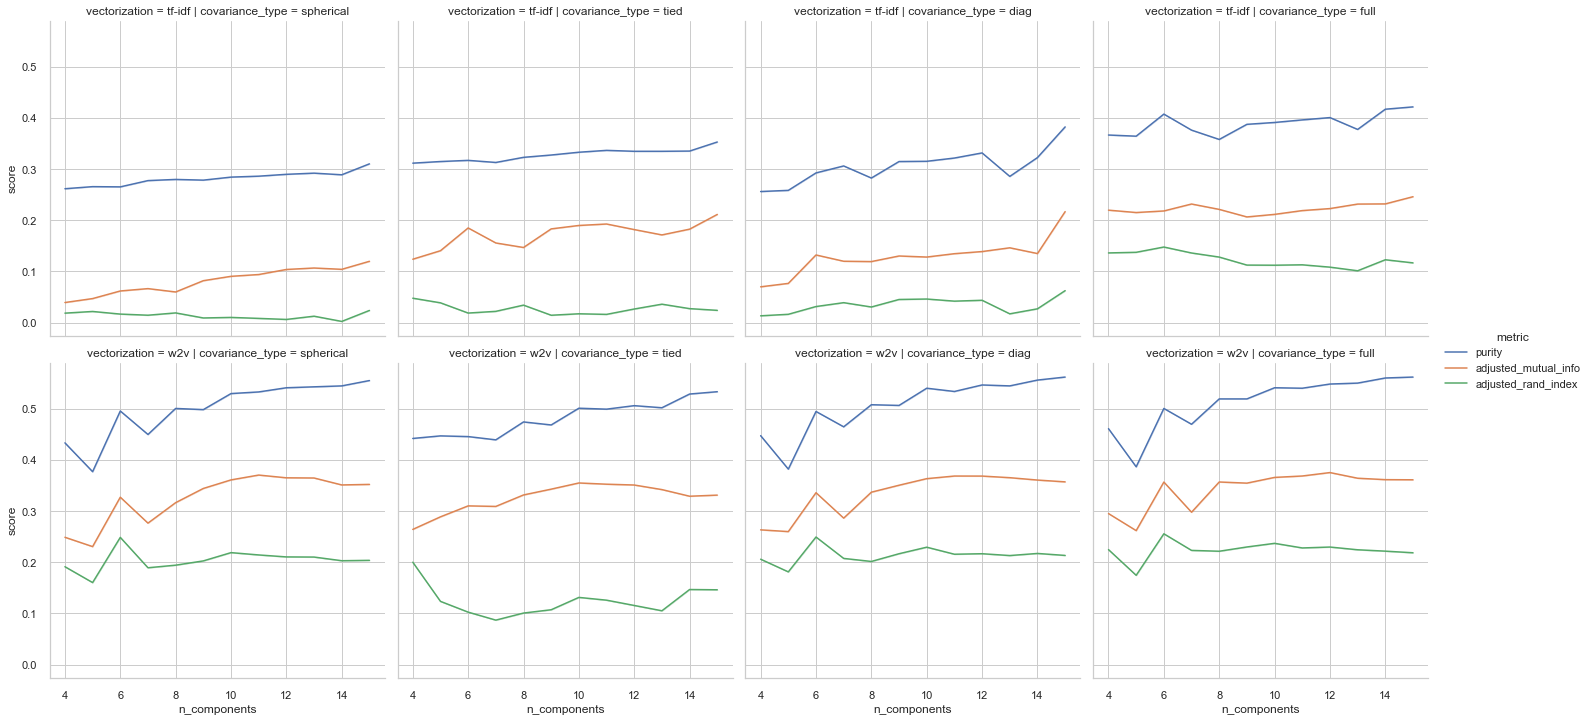

In [13]:
_ = sns.relplot(data=res, x='n_components', y='score', row='vectorization', col='covariance_type', hue="metric", kind='line' )

But again we already know that the documents should be clustered into $14$ groups, therefore, we can limit our focus on how other hyperparameters affect the resulting clustering when `n_components=14`:

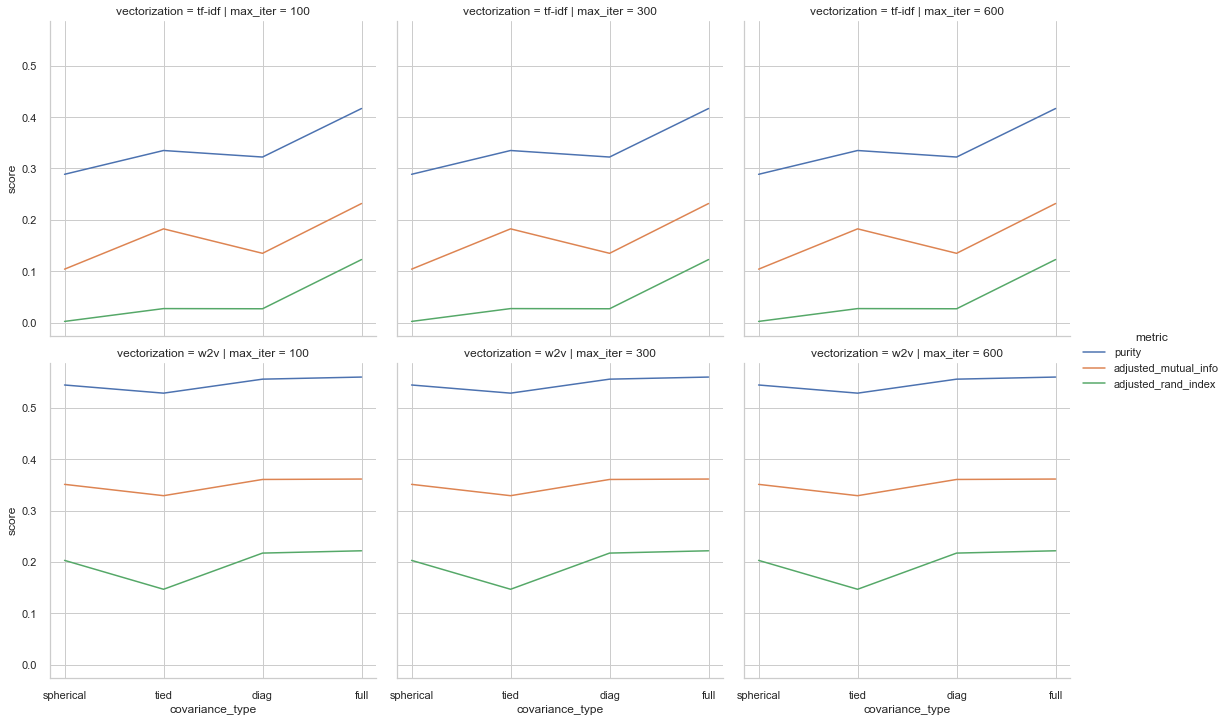

In [14]:
_ = sns.relplot(data=res[res['n_components']==len(major_labels)], x='covariance_type', y='score', col='max_iter', row='vectorization', hue="metric", kind='line')

In [15]:
print('Best set of hyperparameters [tf-idf]')
ftfidf = res[(res['metric'] == 'adjusted_mutual_info') & (res['n_components'] == len(major_labels)) & (res['vectorization'] == 'tf-idf')]
ftfidf[ftfidf['score'] == ftfidf['score'].max()]

Best set of hyperparameters [tf-idf]


,n_components,max_iter,covariance_type,metric,score,vectorization
739,14,100,full,adjusted_mutual_info,0.231836,tf-idf
763,14,300,full,adjusted_mutual_info,0.231836,tf-idf
787,14,600,full,adjusted_mutual_info,0.231836,tf-idf


In [16]:
print('Best set of hyperparameters [w2v]')
fw2v = res[(res['metric'] == 'adjusted_mutual_info') & (res['n_components'] == len(major_labels)) & (res['vectorization'] == 'w2v')]
fw2v[fw2v['score'] == fw2v['score'].max()]

Best set of hyperparameters [w2v]


,n_components,max_iter,covariance_type,metric,score,vectorization
742,14,100,full,adjusted_mutual_info,0.361239,w2v
766,14,300,full,adjusted_mutual_info,0.361239,w2v
790,14,600,full,adjusted_mutual_info,0.361239,w2v


Finalizing clustering with the found hyperparameters:

,algorithm,vectorization,purity,adjusted_mutual_info,adjusted_rand_index
0,Gmm,tf-idf,0.416704,0.231836,0.122800
1,Gmm,w2v,0.559691,0.361239,0.221645


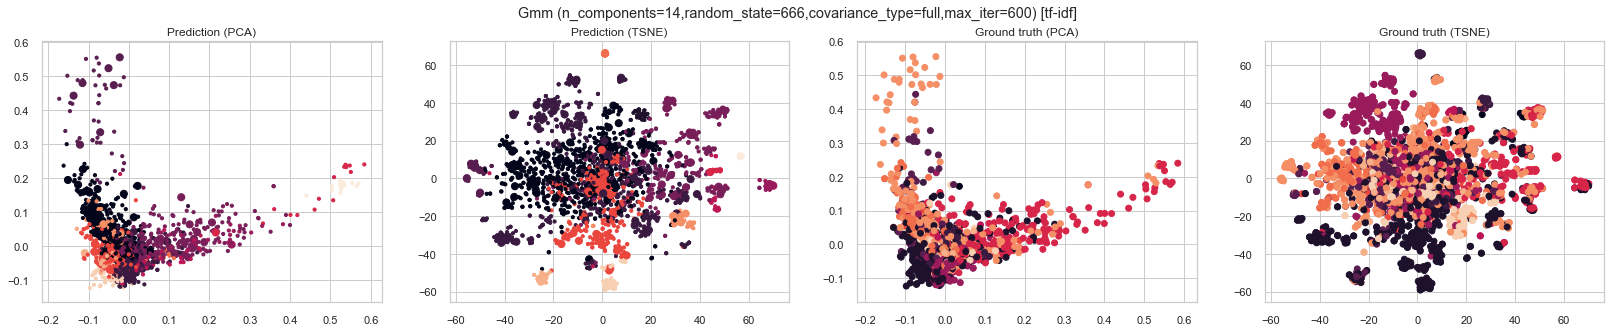

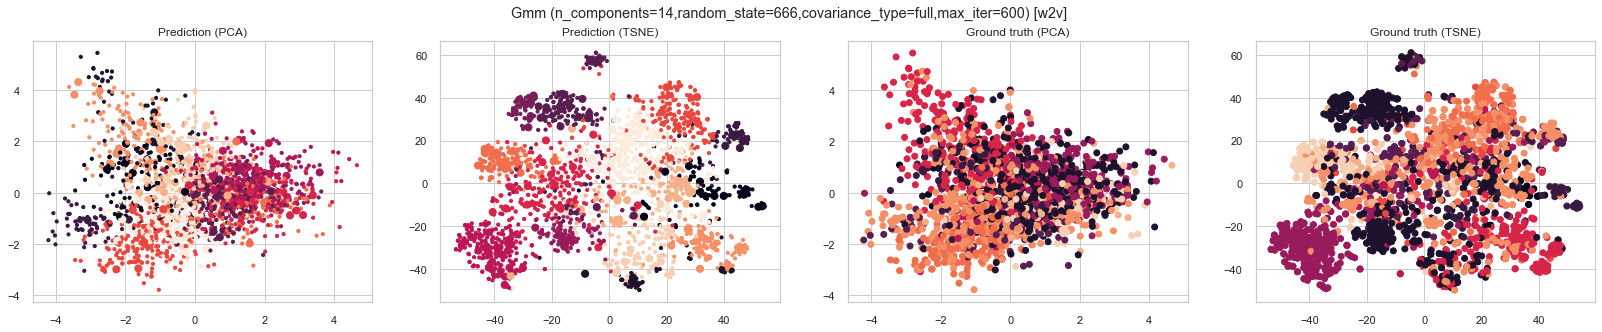

In [17]:
gmm_res = clust.cluster(
    data, 
    algorithm=clust.GMM, 
    tfidf=pca_tfidf, w2v=w2v, 
    options=dict(n_components=len(major_labels), random_state=random_state), 
    options_tfidf=dict(covariance_type='full', max_iter=600),
    options_w2v=dict(covariance_type='full', max_iter=600),
    save=True)
clust.evaluate_results(gmm_res=gmm_res, data=data)

## Hierarchical 
### Supervised Finetuning
Through the same process as in the KMeans, we perform a grid-search on possible hyperparameters to find the best performing set:

In [19]:
variables = dict(
    n_components=list(range(2,16)), 
    linkage=["ward", "complete", "average", "single"], 
    affinity=["euclidean", "l1", "l2","manhattan", "cosine"]
)
res = clust.gridsearch_hyperparams(clust.hierarchical, data=data, tfidf=pca_tfidf, w2v=w2v, variables=variables)

100%|██████████| 280/280 [01:31<00:00,  3.07it/s]


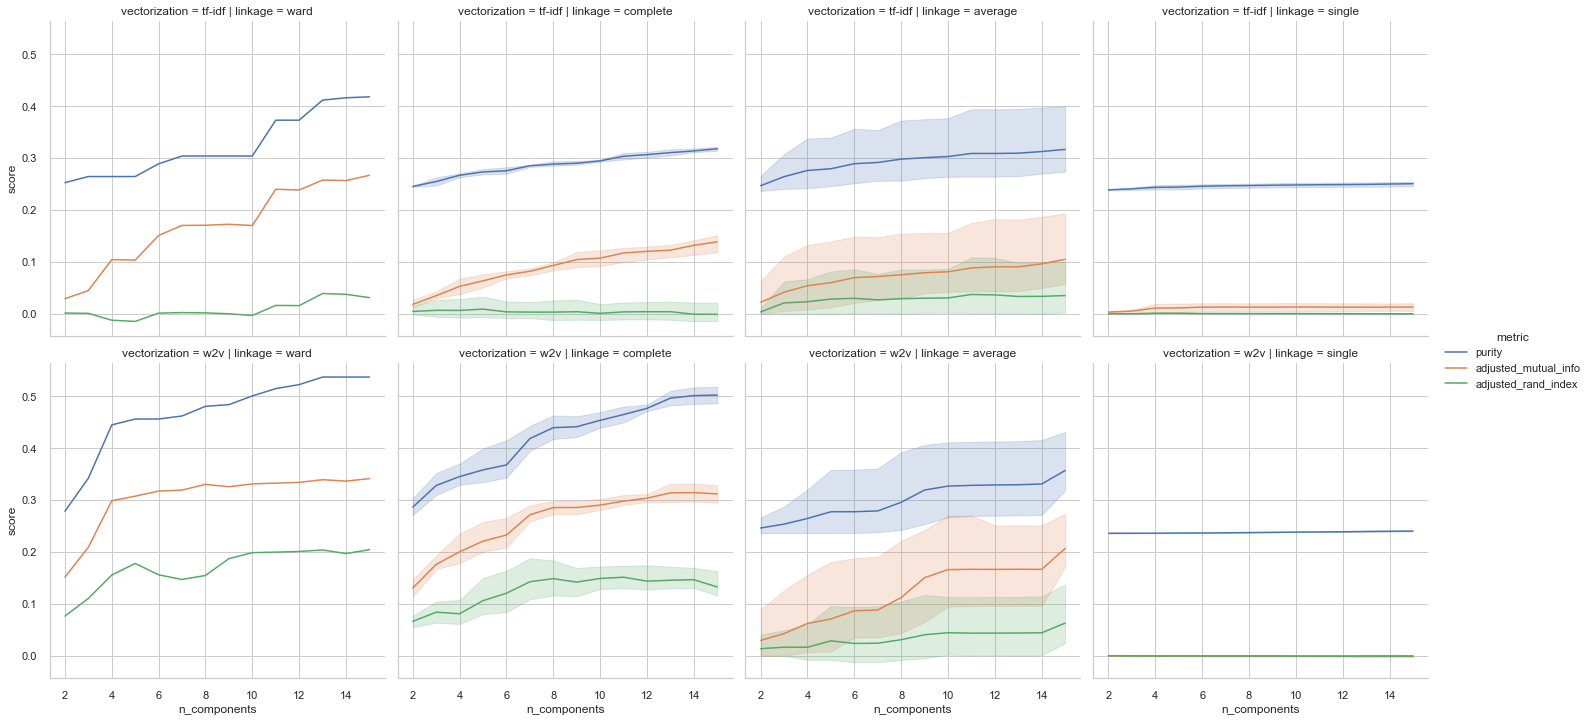

In [20]:
_ = sns.relplot(data=res, x='n_components', y='score', row='vectorization', col='linkage', hue="metric", kind='line')

In [21]:
print('Best set of hyperparameters [tf-idf]')
ftfidf = res[(res['metric'] == 'adjusted_mutual_info') & (res['n_components'] == len(major_labels)) & (res['vectorization'] == 'tf-idf')]
ftfidf[ftfidf['score'] == ftfidf['score'].max()]

Best set of hyperparameters [tf-idf]


,n_components,linkage,affinity,metric,score,vectorization
1213,14,average,cosine,adjusted_mutual_info,0.27747,tf-idf


In [22]:
print('Best set of hyperparameters [w2v]')
fw2v = res[(res['metric'] == 'adjusted_mutual_info') & (res['n_components'] == len(major_labels)) & (res['vectorization'] == 'w2v')]
fw2v[fw2v['score'] == fw2v['score'].max()]

Best set of hyperparameters [w2v]


,n_components,linkage,affinity,metric,score,vectorization
1168,14,complete,l1,adjusted_mutual_info,0.336376,w2v
1180,14,complete,manhattan,adjusted_mutual_info,0.336376,w2v


Finalizing clustering with the best found hyperparameters:

,algorithm,vectorization,purity,adjusted_mutual_info,adjusted_rand_index
0,Hierarchical,tf-idf,0.482070,0.277470,0.165152
1,Hierarchical,w2v,0.522015,0.336376,0.142043


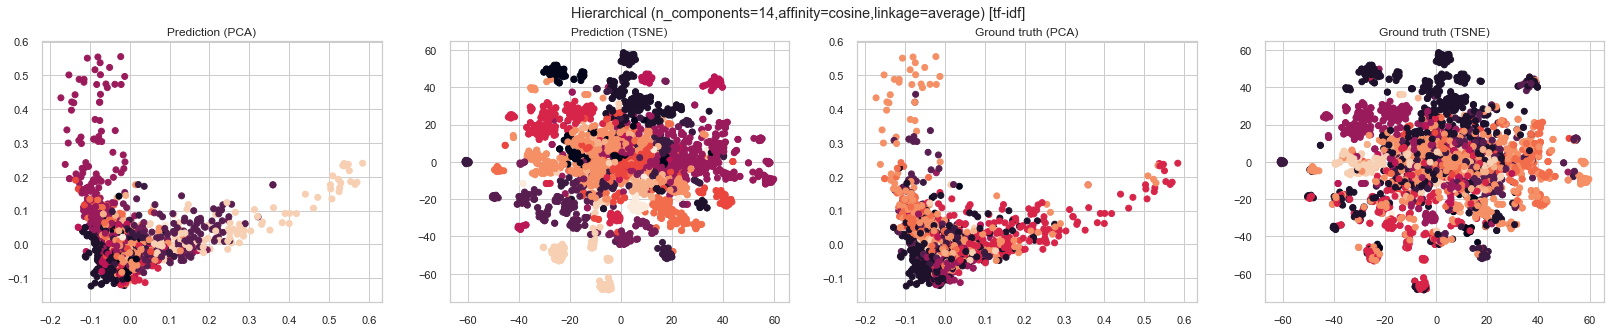

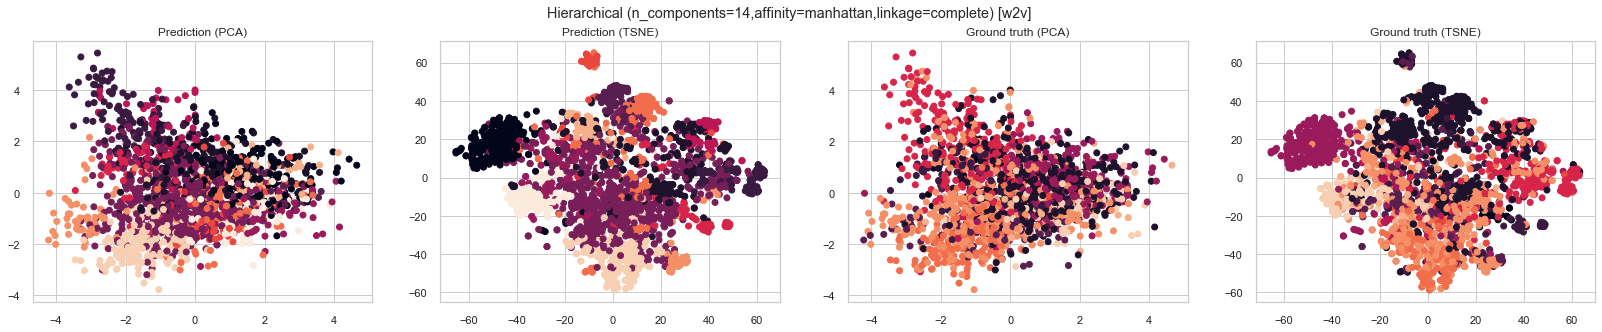

In [25]:
hierarchical_res = clust.cluster(
    data, 
    algorithm=clust.hierarchical, 
    tfidf=pca_tfidf, w2v=w2v, 
    options=dict(n_components=len(major_labels)), 
    options_tfidf=dict(affinity='cosine', linkage='average'),
    options_w2v=dict(affinity='manhattan', linkage='complete'),
    save=True)
clust.evaluate_results(hier_res=hierarchical_res, data=data)

# Final Evaluation
The following shows the best achived results for `n_components=14` which is the desired number of components in the clustering algorithms based on the ground truth labels:

In [26]:
clust.evaluate_results(kmeans_res, gmm_res, hierarchical_res, data)

,algorithm,vectorization,purity,adjusted_mutual_info,adjusted_rand_index
0,Kmeans,tf-idf,0.426237,0.281543,0.067202
1,Kmeans,w2v,0.552429,0.363129,0.213847
2,Gmm,tf-idf,0.416704,0.231836,0.122800
3,Gmm,w2v,0.559691,0.361239,0.221645
4,Hierarchical,tf-idf,0.482070,0.277470,0.165152
5,Hierarchical,w2v,0.522015,0.336376,0.142043
